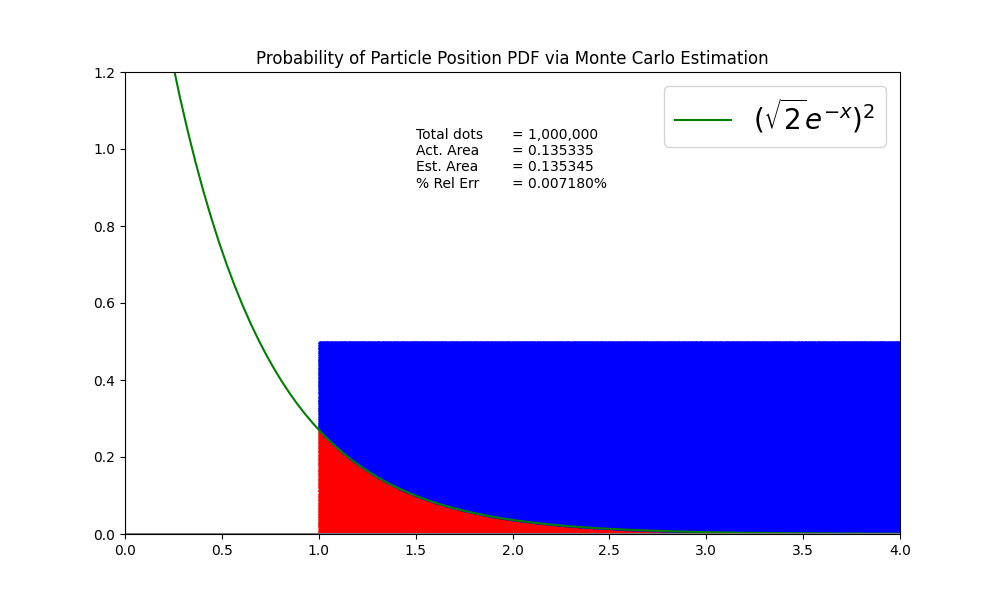

In [6]:
"""particle_location.ipynb"""
# Cell 1
# Code is based on that provided by Dr. Biersach

%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle, Rectangle
from matplotlib.markers import MarkerStyle
from numba import float64, int32, vectorize
from numpy.random import default_rng

sample_area = Rectangle((1, 0), 10, 0.5)

@vectorize([float64(float64)], nopython=True)
def pdf(x):
    """
    calculates pdf
    
    Args:
        x
    Returns: 
        2 * np.exp(-2 * x)
    """
    return 2 * np.exp(-2 * x)

def cdf(x):
    """
    calculates cdf

    Args:
        x
    Returns:
        -np.exp(-2 * x)
    """
    return -np.exp(-2 * x)


@vectorize([float64(float64, float64)], nopython=True)  # type: ignore
def halton(n: float, p: int) -> float:
    h = 0
    f = 1
    while n > 0:
        f: float = f / p
        h += (n % p) * f
        n = int(n / p)
    return h

def plot_pdf(ax):
    """function to estimate the probability that a particle will be found in the region x >= 1nm. The % relative error will be displayed as well"""
    iterations = 1_000_000

    # Sample area big enough to include points above and below
    sample_area = Rectangle((1, 0), 10, 0.5) # setting the root 1,0 and the x and y axis lengths

    # 2 dimensions
    primes: list[int] = [2, 3]

    # Constrained x, y to be in sample space
    x: NDArray[np.float_] = (sample_area.get_x() + halton(np.arange(iterations), primes[0]) * sample_area.get_width())  # type: ignore
    y: NDArray[np.float_] = (sample_area.get_y() + halton(np.arange(iterations), primes[1]) * sample_area.get_height())  # type: ignore

    # Calculate distance above or below curve
    d: NDArray[np.float_] = pdf(x) - y

    x_in: NDArray[np.float_] = x[d >= 0.0]
    y_in: NDArray[np.float_] = y[d >= 0.0]

    x_out: NDArray[np.float_] = x[d < 0.0]
    y_out: NDArray[np.float_] = y[d < 0.0]

    # Plot curve
    pixel_size: float = (72 / ax.figure.dpi) ** 2  # type: ignore
    ax.scatter(x_in, y_in, color="red", marker=MarkerStyle("."), s=pixel_size)
    ax.scatter(x_out, y_out, color="blue", marker=MarkerStyle("."), s=pixel_size)

    # Plot actual pdf curve
    act_x: NDArray[np.float_] = np.linspace(0, 4, 100)
    act_y: NDArray[np.float_] = pdf(act_x)
    ax.plot(
        act_x, act_y, color="green", label=r"${(\sqrt{2} e^{-x})}^2$"
    )

    # Calculate percent relative error using width and height of rectangle - D. Biersach
    est_area: float = (np.count_nonzero(d >= 0.0) / iterations
        * (sample_area.get_width() * sample_area.get_height()))
    # Calculate integral using bounds of rectangle
    act_area: float = cdf(sample_area.get_x() + sample_area.get_width()) - cdf(sample_area.get_x()) #type: ignore
    err: float = (est_area - act_area) / act_area #type: ignore

    ax.set_title("Probability of Particle Position PDF via Monte Carlo Estimation")
    ax.set_xlim(0, 4.0)
    ax.set_ylim(0, 1.2)
    ax.axhline(0, color="gray")
    ax.axvline(0, color="gray")
    ax.legend(loc="upper right", fontsize="20")

    ax.text(1.5, 0.9, "Total dots\nAct. Area\nEst. Area\n% Rel Err", ha="left")

    # fmt: off
    ax.text(2, 0.9,
        f"= {iterations:,}\n= {act_area:.6f}\n= {est_area:.6f}\n= {err:.6%}", ha="left")
    # fmt: on

def main() -> None:
    plt.close("all")
    plt.figure(" ", figsize=(10, 6))
    plot_pdf(plt.axes())
    plt.show()

main()